In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import TopologicalMetrics as tm

In [2]:
def process_dataset():
    entry = []
    count = 0
    with open("facebook_combined.txt", "r") as f:
        for i in f:
            i = i[:-1]
            j,k = map(int, i.split())
            entry.append((j,k))
    return entry

In [3]:
edges = process_dataset()
print(len(edges))
g = nx.Graph()
g.add_edges_from(edges)
print("Number of nodes:", g.number_of_nodes())
print("Number of edges:", g.number_of_edges())

88234
Number of nodes: 4039
Number of edges: 88234


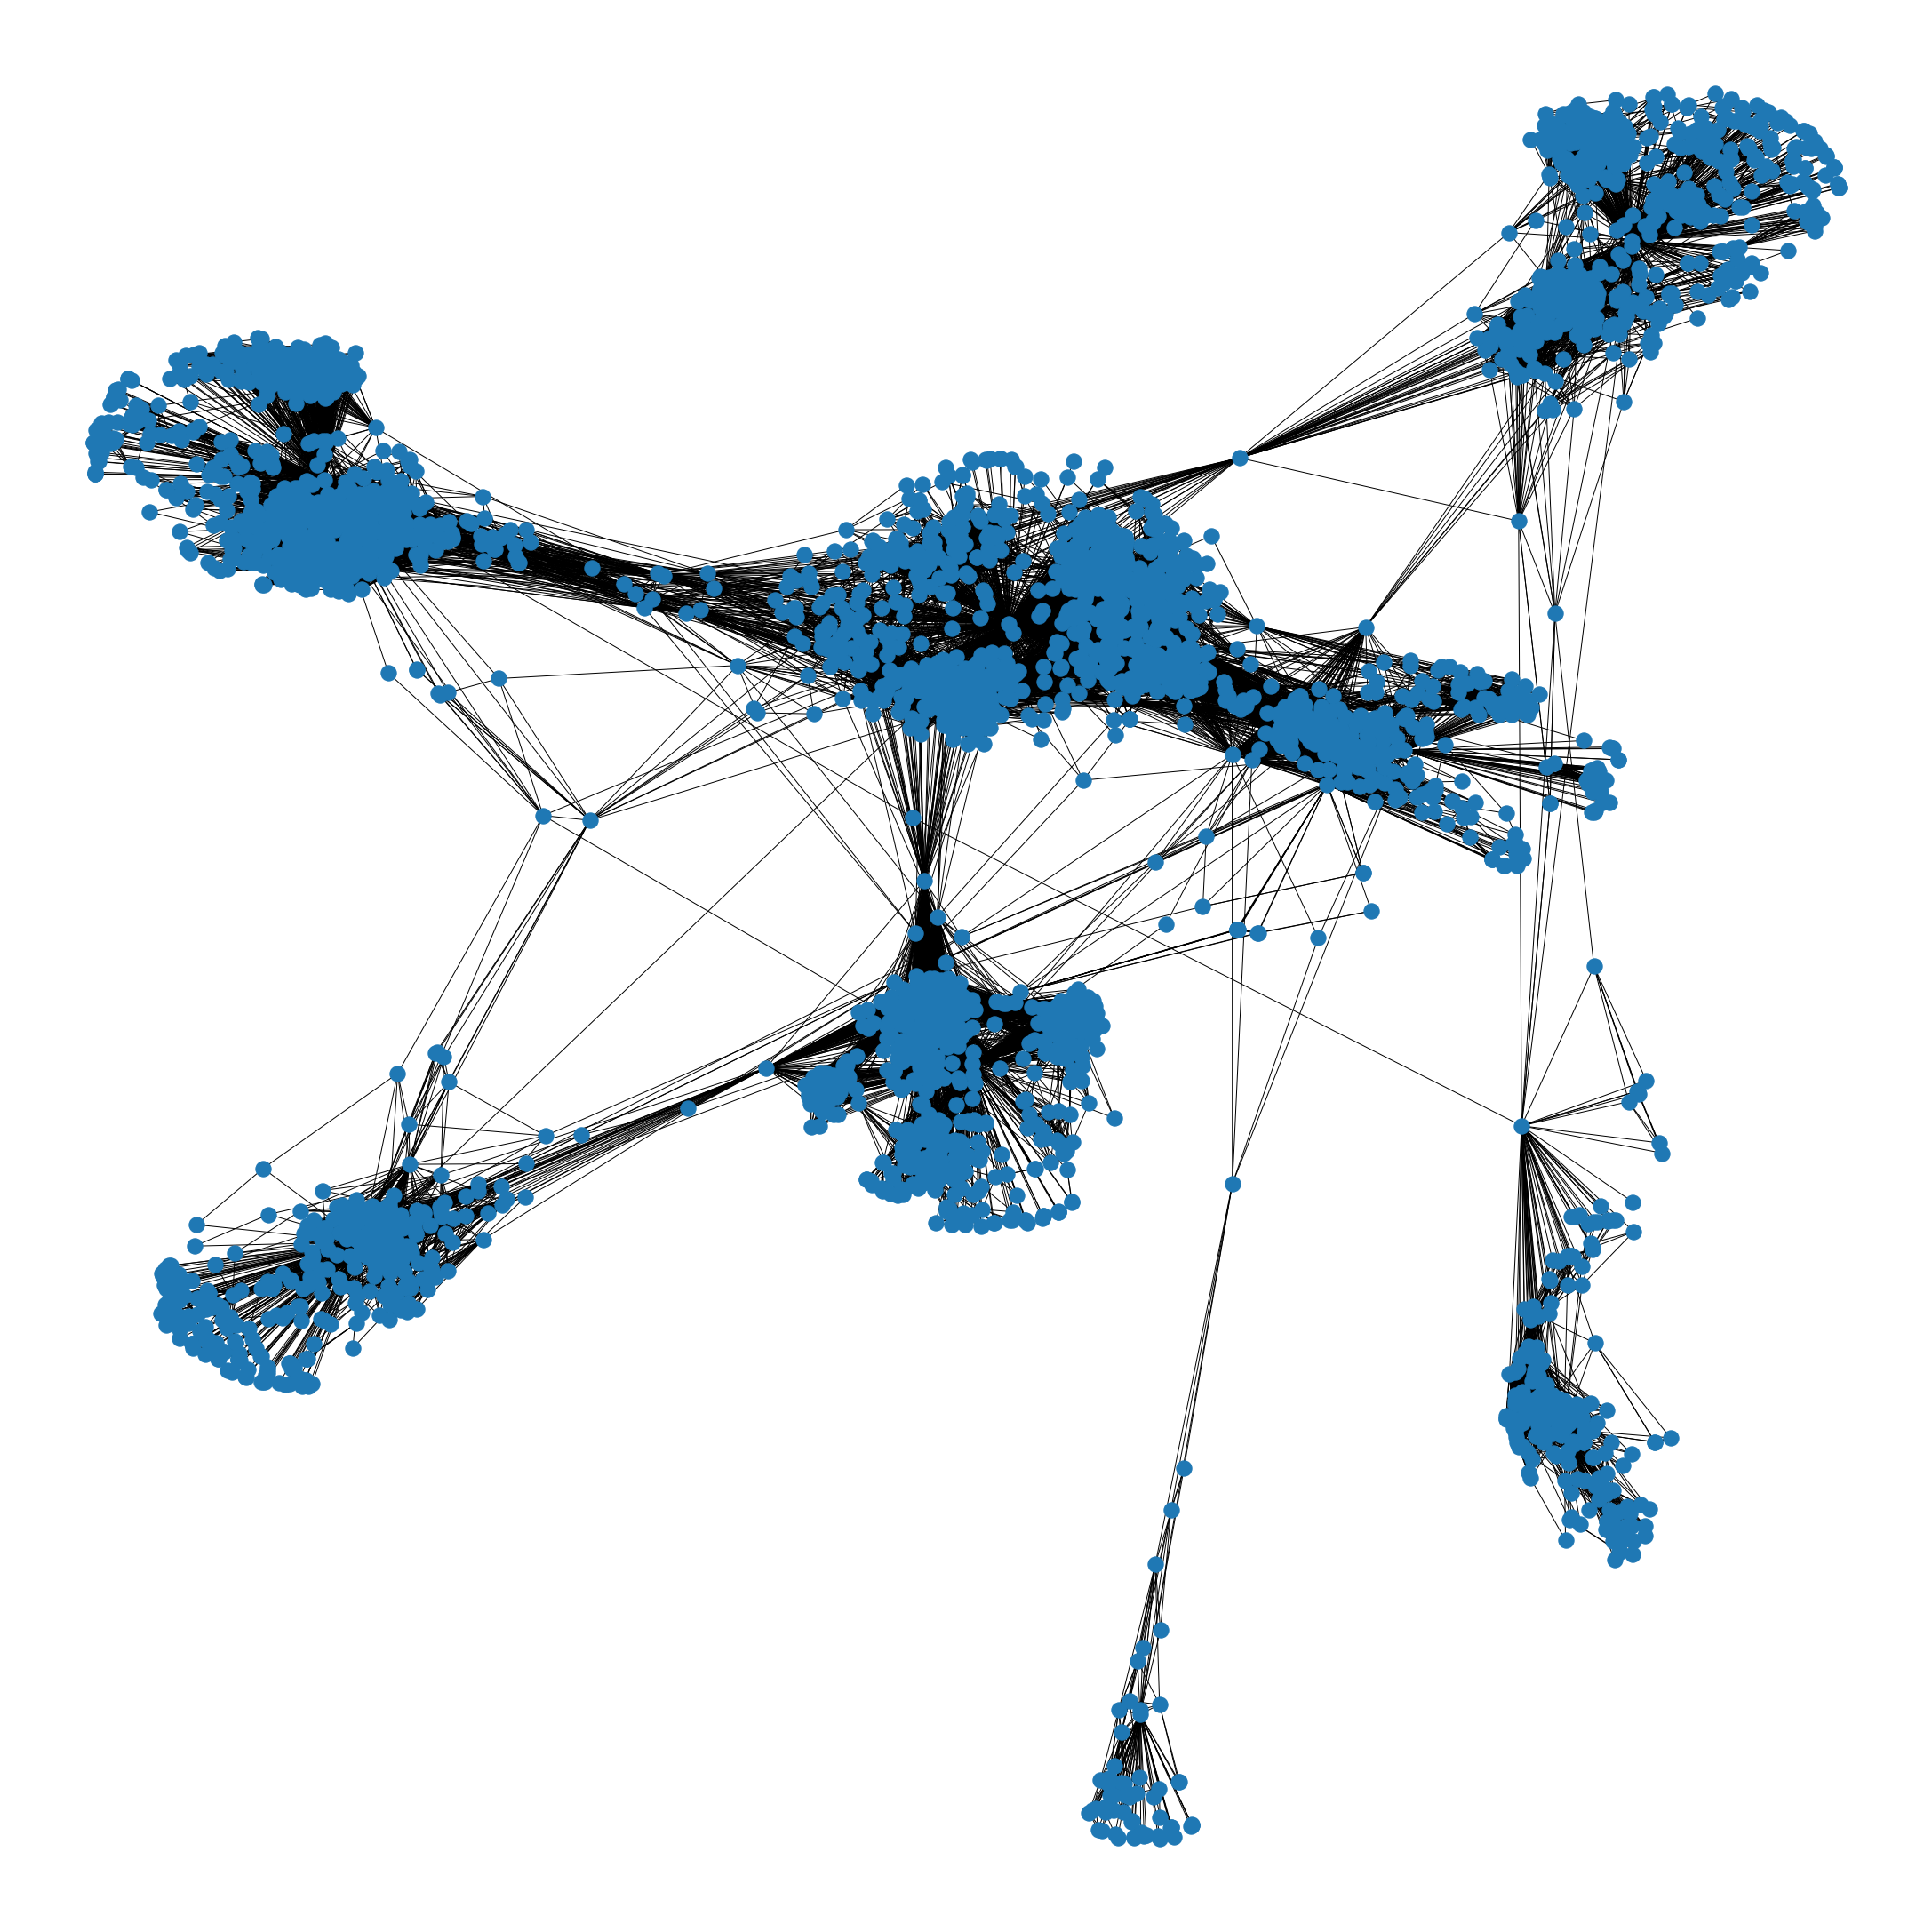

<Figure size 432x288 with 0 Axes>

In [90]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(30,30))
# nx.draw(g)
# plt.show()
# plt.savefig("facebook_dataset.jpeg")

In [4]:
existing_edges = list(g.edges())
print(len(existing_edges))
positive_edges = pd.DataFrame(existing_edges,columns=['node1', 'node2'])
positive_edges['class']='positive'
positive_edges.head()

88234


,node1,node2,class
0,0,1,positive
1,0,2,positive
2,0,3,positive
3,0,4,positive
4,0,5,positive


In [8]:
import random 
non_existing_edges = list(nx.non_edges(g))
print("Total {} non-existing edges present".format(len(non_existing_edges)))
latent_edges = []
impossible_edges = []
print("Screening for the latent edges...")
count = 0
for (u,v) in non_existing_edges:
    count += 1
    if count%1000000==0:
        print("[update] {} edges checked...".format(count))
    if tm.common_neighbors(g,u,v)!=0:
        latent_edges.append((u,v))
    else:
        impossible_edges.append((u,v))
print("Total {} latent edges found".format(len(latent_edges)))
print("Total {} impossible edges found".format(len(impossible_edges)))

Total 8066507 non-existing edges present
Screening for the latent edges...
[update] 1000000 edges checked...
[update] 2000000 edges checked...
[update] 3000000 edges checked...
[update] 4000000 edges checked...
[update] 5000000 edges checked...
[update] 6000000 edges checked...
[update] 7000000 edges checked...
[update] 8000000 edges checked...
Total 1358067 latent edges found
Total 6708440 impossible edges found


In [9]:
print("Sampling out 100000 negative edges for training and testing...")
negative_edges = random.sample(latent_edges, 75000)
negative_edges += random.sample(impossible_edges, 25000)
print(len(negative_edges))
negative_edges = pd.DataFrame(negative_edges, columns=['node1', 'node2'])
negative_edges['class']='negative'
negative_edges.head()

Sampling out 100000 negative edges for training and testing...
100000


,node1,node2,class
0,388,448,negative
1,2700,2964,negative
2,1303,1444,negative
3,2668,2840,negative
4,170,174,negative


In [12]:
print("Entire edge set (positive/existing edges + negative/latent edges):")
edges = pd.concat([positive_edges, negative_edges])
print(len(edges))
edges

Entire edge set (positive/existing edges + negative/latent edges):
188234


,node1,node2,class
0,0,1,positive
1,0,2,positive
2,0,3,positive
3,0,4,positive
4,0,5,positive
...,...,...,...
99995,2708,3710,negative
99996,262,3686,negative
99997,1548,1976,negative
99998,43,1455,negative


In [24]:
# shuffle in-place
# edges = edges.sample(frac=1).reset_index(drop=True)

In [13]:
import TopologicalMetrics as tm
feature_set_dict = {}
count = 0
for i in range(len(edges)):
    u = edges.iloc[i]['node1']
    v = edges.iloc[i]['node2']
    l = []
    cn = tm.common_neighbors(g,u,v)
    count += 1
    if count%20000 == 0:
        print("Done with {} node-pairs".format(count))
    if cn != 0:
        l.append(float(cn))
        l.append(tm.jaccard_coefficient(g,u,v))
        l.append(tm.sorensen_index(g,u,v))
        l.append(tm.leicht_holme_nerman(g,u,v))
        l.append(tm.salton_cosine_similarity(g,u,v))
        l.append(tm.hub_promoted_index(g,u,v))
        l.append(tm.hub_depressed_index(g,u,v))
        l.append(float(tm.preferential_attachment(g,u,v)))
        l.append(tm.adamic_adar(g,u,v))
        l.append(tm.resource_allocation(g,u,v))
        feature_set_dict[(u,v)] = l
    if cn == 0:
        feature_set_dict[(u,v)] = [0.,0.,0.,0.,0.,0.,0., float(tm.preferential_attachment(g,u,v)),0.,0.]

Done with 20000 node-pairs
Done with 40000 node-pairs
Done with 60000 node-pairs
Done with 80000 node-pairs
Done with 100000 node-pairs
Done with 120000 node-pairs
Done with 140000 node-pairs
Done with 160000 node-pairs
Done with 180000 node-pairs


In [15]:
dict(list(feature_set_dict.items())[0:2])

{(0, 1): [16.0,
  0.04597701149425287,
  0.04395604395604396,
  0.0027123241227326664,
  0.20831991254731907,
  0.9411764705882353,
  0.04610951008645533,
  5899.0,
  5.296262890440262,
  0.8365708769714377],
 (0, 2): [9.0,
  0.02586206896551724,
  0.025210084033613446,
  0.0025936599423631124,
  0.1527839634296349,
  0.9,
  0.025936599423631124,
  3470.0,
  3.281956150615995,
  0.5876150595190842]}

In [39]:
import warnings
warnings.filterwarnings("ignore")

feature_set_df = edges.copy()
slength = len(feature_set_df['node1'])
feature_set_df['cn'] = 0.
feature_set_df['jc'] = 0.
feature_set_df['si'] = 0.
feature_set_df['lhn'] = 0.
feature_set_df['scs'] = 0.
feature_set_df['hpi'] = 0.
feature_set_df['hdi'] = 0.
feature_set_df['pa'] = 0.
feature_set_df['aa'] = 0.
feature_set_df['ra'] = 0.
print(feature_set_df.head())
count = 0
for i in range(len(edges)):
    u = edges.iloc[i]['node1']
    v = edges.iloc[i]['node2']
    cn = feature_set_df['cn'][i] = tm.common_neighbors(g,u,v)
    count += 1
    if count%10000 == 0:
        print("Done with {} node-pairs".format(count))
    if cn != 0:
        feature_set_df['jc'][i] = tm.jaccard_coefficient(g,u,v)
        feature_set_df['si'][i] =tm.sorensen_index(g,u,v)
        feature_set_df['lhn'][i] = tm.leicht_holme_nerman(g,u,v)
        feature_set_df['scs'][i] = tm.salton_cosine_similarity(g,u,v)
        feature_set_df['hpi'][i] = tm.hub_promoted_index(g,u,v)
        feature_set_df['hdi'][i] = tm.hub_depressed_index(g,u,v)
        feature_set_df['pa'][i] = float(tm.preferential_attachment(g,u,v))
        feature_set_df['aa'][i] = tm.adamic_adar(g,u,v)
        feature_set_df['ra'][i] = tm.resource_allocation(g,u,v)
        
feature_set_df.head()

   node1  node2     class   cn   jc   si  lhn  scs  hpi  hdi   pa   aa   ra
0      0      1  positive  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1      0      2  positive  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2      0      3  positive  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3      0      4  positive  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4      0      5  positive  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
Done with 10000 node-pairs
Done with 20000 node-pairs
Done with 30000 node-pairs
Done with 40000 node-pairs
Done with 50000 node-pairs
Done with 60000 node-pairs
Done with 70000 node-pairs
Done with 80000 node-pairs
Done with 90000 node-pairs
Done with 100000 node-pairs
Done with 110000 node-pairs
Done with 120000 node-pairs
Done with 130000 node-pairs
Done with 140000 node-pairs
Done with 150000 node-pairs
Done with 160000 node-pairs
Done with 170000 node-pairs
Done with 180000 node-pairs


,node1,node2,class,cn,jc,si,lhn,scs,hpi,hdi,pa,aa,ra
0,0,1,positive,16.0,0.045977,0.043956,0.002712,0.208320,0.941176,0.046110,5899.0,5.296263,0.836571
1,0,2,positive,9.0,0.025862,0.025210,0.002594,0.152784,0.900000,0.025937,3470.0,3.281956,0.587615
2,0,3,positive,16.0,0.045977,0.043956,0.002712,0.208320,0.941176,0.046110,5899.0,5.368408,0.925900
3,0,4,positive,9.0,0.025862,0.025210,0.002594,0.152784,0.900000,0.025937,3470.0,4.220642,1.066667
4,0,5,positive,12.0,0.034483,0.033333,0.002660,0.178667,0.923077,0.034582,4511.0,5.222650,1.143898


In [40]:
feature_set_df.to_csv("facebook_feature_set.csv")

In [43]:
len(set(g.neighbors(0)).intersection(set(g.neighbors(11))))

0

In [104]:
# refine edges dataframe
idx_to_drop = []

for i in range(len(edges)):
    u = edges.iloc[i]['node1']
    v = edges.iloc[i]['node2']
    if (u,v) in latent_links.keys():
        continue
    else:
        idx_to_drop.append(i)

print(len(edges))
print(len(idx_to_drop))
print(len(latent_links))

188234
83209
105025


In [105]:
for i in idx_to_drop:
    edges = edges.drop(i)
    
print(len(edges))
edges

KeyboardInterrupt: 

-----------------DEMO---------------

In [36]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
df = pd.DataFrame(np.array([[1, 10, 3], [2, 5, 6], [7, 8, 9], [2, 10, 20]], dtype=object), columns=['a', 'b', 'c'])
dct = {(1,10):['x','y','z'], (2,10):['x','b','c'], (5,70):['p','q','r']}
# print(len(df))
print(df)
print(dct.keys())
# drop = []
# for i in range(len(df)):
#     u = df.iloc[i]['a']
#     v = df.iloc[i]['b']
#     if (u,v) in dct.keys():
#         print("i:",i)
#         print(u)
#         print(v)
#         drop.append(i)

# print(drop)
# for i in drop:
#     df = df.drop(i)

slength = len(df['a'])
# print(slength)
# df['d'] = pd.Series(np.random.randn(slength), index=df.index)

df = df.assign(d=pd.Series(np.random.randn(slength)).values)
for i in range(5):
    df['d'][i] = i*2

df

   a   b   c
0  1  10   3
1  2   5   6
2  7   8   9
3  2  10  20
dict_keys([(1, 10), (2, 10), (5, 70)])


,a,b,c,d
0,1,10,3,0.0
1,2,5,6,2.0
2,7,8,9,4.0
3,2,10,20,6.0


In [11]:
import networkx as nx

g_demo = nx.Graph()
g_demo.add_edges_from([(1,2),(1,3),(1,6),(2,4),(2,5),(2,3),(3,5),(3,4),(4,5),(4,6),(6,7),(4,7)])

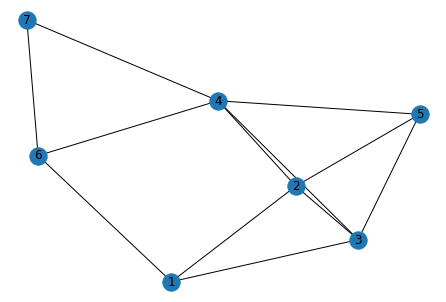

In [12]:
nx.draw(g_demo, with_labels=True)

In [7]:
edges = nx.edges(g_demo)
len(list(edges))

12

In [8]:
non_edges = nx.non_edges(g_demo)
len(list(non_edges))

9

In [16]:
from TopologicalMetrics import common_neighbors

common_neighbors(g_demo,3,2)

3